# Extract a region of the total Himawari-8 dataset

 To put onto cloudstor

In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(40)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Client Scheduler: tcp://146.118.38.114:35671 Dashboard: http://146.118.38.114:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import pandas as pd
from matplotlib import animation
import glob
import cmocean
import cartopy
import zarr

from matplotlib.colors import LightSource
from scipy import ndimage
# import geoviews as gv
# import geoviews.feature as gf

In [4]:
# Open the object as a zarr file
outpath = '/home/mrayson/scratch/HIMAWARI/raw_zarr'
ds = xr.open_zarr(outpath)
ds.time.values[0],ds.time.values[-1],ds

(numpy.datetime64('2016-01-01T00:00:17.000000000'),
 numpy.datetime64('2019-12-31T23:00:17.000000000'),
 <xarray.Dataset>
 Dimensions:                  (lat: 6001, lon: 6001, time: 34688)
 Coordinates:
   * lat                      (lat) float32 60.0 59.98 59.96 ... -59.979996 -60.0
   * lon                      (lon) float32 80.0 80.02 80.04 ... 199.98 200.0
   * time                     (time) datetime64[ns] 2016-01-01T00:00:17 ... 2019-12-31T23:00:17
 Data variables:
     sea_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(1, 6001, 6001), meta=np.ndarray>
 Attributes:
     Conventions:                CF-1.4,Unidata Observation Dataset v1.0
     Metadata_Conventions:       Unidata Observation Dataset v1.0
     acknowledgment:             Please acknowledge the use of these data with...
     algorithm_version:          1.02
     cdm_data_type:              grid
     comment:                    SST from AHI
     contact:                    ghrsst@eorc.jaxa.jp
     c

In [9]:
#!du -h -d 1 /home/mrayson/scratch/HIMAWARI/
!ls -lah /home/mrayson/scratch/HIMAWARI/

total 126G
drwxr-sr-x  10 mrayson pawsey0106 4.0K Apr 24 15:06 .
drwxr-s---   6 mrayson pawsey0106 4.0K Apr 24 14:11 ..
-rw-r--r--   1 mrayson pawsey0106 2.8M Apr 20 23:59 copyjob-4418514.out
-rw-r--r--   1 mrayson pawsey0106 2.8M Apr 23 16:29 copyjob-4514618.out
-rw-r--r--   1 mrayson pawsey0106  33G Jan 20 16:52 himawari-nws.tar.gz
drwxr-sr-x+  2 mrayson pawsey0106 2.4M Jan 23 21:18 NWS
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 20 23:59 NWS_zarr
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 24 15:47 NWS_zarr_c
-rw-r--r--   1 mrayson pawsey0106  47G Apr 23 16:29 NWS_zarr_c.zip
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 24 14:55 NWS_zarr_timechunk
-rw-r--r--   1 mrayson pawsey0106  47G Apr 20 23:59 NWS_zarr.zip
drwxr-sr-x+  2 mrayson pawsey0106 4.7M Jan 23 21:18 raw
drwxr-sr-x   6 mrayson pawsey0106 4.0K Jan 24 11:10 raw_zarr
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 20 22:35 test_NWS_zarr
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 23 17:59 test_NWS_zarr_c
-rw-r--r--   1 mrayson pawsey0

In [5]:
ds.time.values[0], ds.time.values[-1]

(numpy.datetime64('2016-01-01T00:00:17.000000000'),
 numpy.datetime64('2019-12-31T23:00:17.000000000'))

In [6]:
# Write 6 month blocks to zarr and append
extents = [110,145,-25,-5]
outpath = '/home/mrayson/scratch/HIMAWARI/NWS_zarr_timechunk'

tstarts = pd.date_range(ds.time.values[0],ds.time.values[-1],freq='180d').values
tends = np.hstack([tstarts[1::],ds.time.values[-1]])
nt = tends.shape[0]
tstarts,tends, nt

(array(['2016-01-01T00:00:17.000000000', '2016-06-29T00:00:17.000000000',
        '2016-12-26T00:00:17.000000000', '2017-06-24T00:00:17.000000000',
        '2017-12-21T00:00:17.000000000', '2018-06-19T00:00:17.000000000',
        '2018-12-16T00:00:17.000000000', '2019-06-14T00:00:17.000000000',
        '2019-12-11T00:00:17.000000000'], dtype='datetime64[ns]'),
 array(['2016-06-29T00:00:17.000000000', '2016-12-26T00:00:17.000000000',
        '2017-06-24T00:00:17.000000000', '2017-12-21T00:00:17.000000000',
        '2018-06-19T00:00:17.000000000', '2018-12-16T00:00:17.000000000',
        '2019-06-14T00:00:17.000000000', '2019-12-11T00:00:17.000000000',
        '2019-12-31T23:00:17.000000000'], dtype='datetime64[ns]'),
 9)

In [8]:
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)

mode='w'
append_dim=None
encoding = {'sea_surface_temperature': {'compressor': compressor}}
consolidated = True
chunks={'time':-1,'lat':-1,'lon':1}

ii=0
for t1,t2 in zip(tstarts,tends):
    ii+=1

    print(72*'#')
    print(t1,t2,ii,nt)
    
    # Restart from a point
    if ii < 8:
        append_dim='time'
        mode='a'
        encoding=None
        continue
        
    # Slice the object
    dsout = ds.sel(lon=slice(extents[0], extents[1]), 
                   lat=slice(extents[3], extents[2]),
                  time=slice(t1,t2)
                  ).chunk(chunks)
    if ii == 1:
        print(dsout)
    
    if ii == nt:
        consolidated=True
    
    dsout.to_zarr(outpath, encoding=encoding,\
             mode=mode, append_dim=append_dim, consolidated=consolidated)
    
    append_dim='time'
    mode='a'
    encoding=None


print('Done. Written to file: ',outpath)
    

########################################################################
2016-01-01T00:00:17.000000000 2016-06-29T00:00:17.000000000 1 9
########################################################################
2016-06-29T00:00:17.000000000 2016-12-26T00:00:17.000000000 2 9
########################################################################
2016-12-26T00:00:17.000000000 2017-06-24T00:00:17.000000000 3 9
########################################################################
2017-06-24T00:00:17.000000000 2017-12-21T00:00:17.000000000 4 9
########################################################################
2017-12-21T00:00:17.000000000 2018-06-19T00:00:17.000000000 5 9
########################################################################
2018-06-19T00:00:17.000000000 2018-12-16T00:00:17.000000000 6 9
########################################################################
2018-12-16T00:00:17.000000000 2019-06-14T00:00:17.000000000 7 9
#########################################

In [9]:
ds2 = xr.open_zarr(outpath, consolidated=True)
ds2

<xarray.Dataset>
Dimensions:                  (lat: 1001, lon: 1751, time: 39016)
Coordinates:
  * lat                      (lat) float32 -5.0 -5.0199966 ... -24.979996 -25.0
  * lon                      (lon) float32 110.0 110.02 110.04 ... 144.98 145.0
  * time                     (time) datetime64[ns] 2016-01-01T00:00:17 ... 2019-12-31T23:00:17
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(4319, 1001, 1), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.4,Unidata Observation Dataset v1.0
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    algorithm_version:          1.02
    cdm_data_type:              grid
    comment:                    SST from AHI
    contact:                    ghrsst@eorc.jaxa.jp
    creator_email:              ghrsst@eorc.jaxa.jp
    creator_name:               Japan Aerospace Exploration Agency
    creator_url:                http://www.eorc.jaxa.jp/en/index.php
    date_created:               20191204T022743Z
    easternmost_longitude:      -160.0
    file_quality_level:         1
    gds_version_id:             02.0
    geospatial_lat_resolution:  0.019999999552965164
    geospatial_lat_units:       degrees north
    geospatial_lon_resolution:  0.019999999552965164
    geospatial_lon_units:       degrees east
    history:                    L2P data file originally produced by JAXA
    id:                         H08_AHI-JAXA-L3C-v01.2
    institution:                Japan Aerospace Exploration Agency(JAXA)
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD)
    license:                    GHRSST protocol describes data use as free an...
    metadata_link:              TBD
    naming_authority:           org.ghrsst
    netcdf_version_id:          4.3.2
    northernmost_latitude:      60.0
    platform:                   Himawari-8
    processing_level:           L3C
    product_version:            1.2
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_email:            ghrsst-po@nceo.ac.uk
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    references:                 TBD
    sensor:                     AHI
    source:                     AHI_L2_SST,OISST,ECMWF,AMSR2_L3_SIC
    southernmost_latitude:      -60.0
    spatial_resolution:         0.02 deg
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    start_time:                 20191201T000000Z
    stop_time:                  20191201T010000Z
    summary:                    TBD
    time_coverage_end:          20191201T010000Z
    time_coverage_start:        20191201T000000Z
    title:                      Sea Surface Temperature from AHI onboard Hima...
    uuid:                       c3faab4d-e798-4a83-be96-41f517e13e86
    westernmost_longitude:      80.0

CPU times: user 84.4 ms, sys: 0 ns, total: 84.4 ms
Wall time: 172 ms


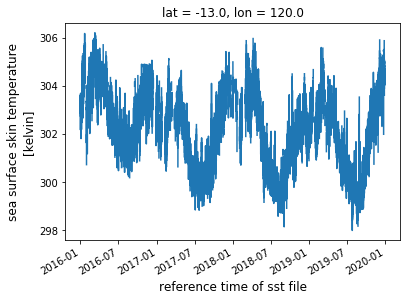

In [11]:
%%time
plt.figure()
ds2['sea_surface_temperature'].sel(lon=120,lat=-13,method='nearest').plot()